In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import bokeh
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Tabs
from bokeh.layouts import row, column, gridplot
from bokeh.models.tools import HoverTool
from bokeh.models.annotations import Title
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import Series
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import sklearn.metrics as metrics
import statsmodels.api as sm
import random
drive.mount('/content/gdrive')

import pandas as pd
df = pd.read_csv('BBCA.JK.csv')

from statsmodels.tsa.arima.model import ARIMA

df

Mounted at /content/gdrive


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-02,8575.0,8600.0,8500.0,8550.0,8342.644531,10653900
1,2023-01-03,8550.0,8600.0,8525.0,8550.0,8342.644531,27399100
2,2023-01-04,8525.0,8575.0,8350.0,8350.0,8147.495605,90918800
3,2023-01-05,8350.0,8375.0,8150.0,8250.0,8049.920898,128838500
4,2023-01-06,8100.0,8325.0,8100.0,8300.0,8098.708008,69286600
...,...,...,...,...,...,...,...
234,2023-12-21,9300.0,9325.0,9250.0,9325.0,9325.000000,88116700
235,2023-12-22,9275.0,9350.0,9275.0,9325.0,9325.000000,64449600
236,2023-12-27,9375.0,9400.0,9325.0,9375.0,9375.000000,64464700
237,2023-12-28,9325.0,9425.0,9325.0,9400.0,9400.000000,70184600


In [ ]:
#UBAH FORMAT PADA DATASET
df["Date"] = pd.to_datetime(df["Date"], format='ISO8601')

#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()

#buat source
source = ColumnDataSource(df)

#membuat figure
awal = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label='Harga saham BBCA')
awal.line(x="Date", y="Close", source = source, line_width=2, legend_label="Harga saham BBCA", color='maroon')
awal.legend.location = 'top_left'

#membuat hover
hover = HoverTool(tooltips=[('IDR', '@Close'), ('Date', '$x{%F}')], mode='vline', formatters={"$x": "datetime"})
awal.add_tools(hover)

#menampilkan grafik
show(awal)



<Axes: >

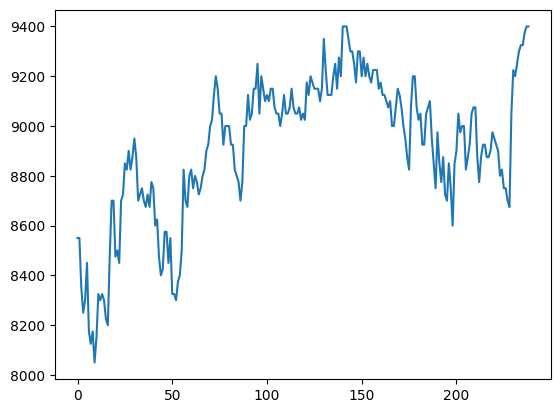

In [ ]:
#NILAI KESALAHAN ET, untuk men setting nilai kesalahan eror saat
series = [random.random() for i in range(len(df))]
series = Series(series)

df["et"] = series

df['Close'].dropna().plot()

In [ ]:
#Membuat fungsi ADF Testing
def ADF_Test(df):
    result = adfuller(df)
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
      print("Data tidak stasionaire")
      print()
      print()
    else:
      print("Data Stasionaire")
      print()
      print()

ADF_Test(df["Close"])

p-value: 0.123281
Data tidak stasionaire




p-value: 0.000000
Data Stasionaire




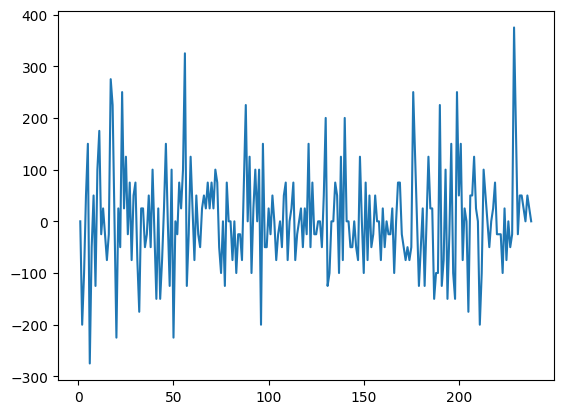

In [ ]:
#Differencing
df['diff'] = df['Close'] - df['Close'].shift(1)

#Plot data differencing
df['diff'].dropna().plot()

#uji stasioneritas menggunakan data differencing
ADF_Test(df["diff"].dropna())

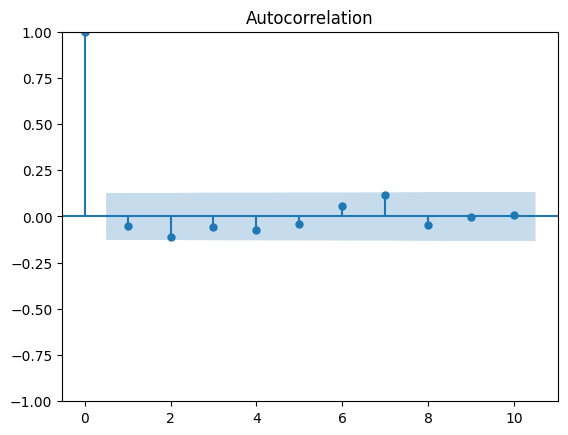

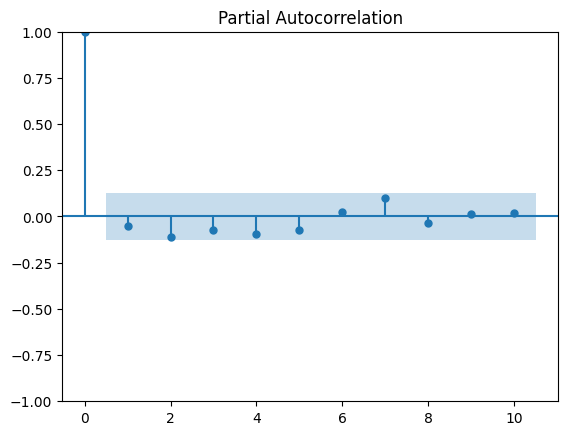

In [ ]:
#Plot ACF untuk menentukan parameter q
sm.graphics.tsa.plot_acf(df["diff"].dropna(),lags=10)

#Plot PACF untuk menentukan parameter p
sm.graphics.tsa.plot_pacf(df["diff"].dropna(),lags=10)

#Parameter d didapat dari jumlah derajat differencing (d=1)

plt.show()

In [ ]:
aic = []
mod = ARIMA(df["Close"].dropna(), order=(0,1,0))
mod = mod.fit()
aic.append([0,1,0,mod.aic])

mod1 = ARIMA(df["Close"].dropna(), order=(0,1,2))
mod1 = mod1.fit()
aic.append([0,1,2,mod1.aic])

mod2 = ARIMA(df["Close"].dropna(), order=(2,1,0))
mod2 = mod2.fit()
aic.append([2,1,0,mod2.aic])

print(aic)

[[0, 1, 0, 2852.375906299446], [0, 1, 2, 2851.168404313574], [2, 1, 0, 2852.4917657342307]]


In [ ]:
model = ARIMA(df["Close"].dropna(), order=(0,1,2))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  239
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1422.584
Date:                Sat, 04 May 2024   AIC                           2851.168
Time:                        13:43:54   BIC                           2861.585
Sample:                             0   HQIC                          2855.367
                                - 239                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0809      0.058     -1.404      0.160      -0.194       0.032
ma.L2         -0.1473      0.064     -2.288      0.022      -0.274      -0.021
sigma2      9122.4910    658.928     13.844      0.000    7831.017    1.04e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                26.63
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.54
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import statsmodels.api as sm
res2 = ARIMA(df["Close"].dropna(), order=(0,1,2)).fit()
ljungbox=[]
for m in range(5):
  m+=1
  h2 = sm.stats.acorr_ljungbox(res2.resid, lags=[m])
  ljungbox.append([m, h2])
print(ljungbox)

[[1,     lb_stat  lb_pvalue
1  0.000021   0.996304], [2,     lb_stat  lb_pvalue
2  0.111768   0.945649], [3,     lb_stat  lb_pvalue
3  0.170474   0.982209], [4,     lb_stat  lb_pvalue
4  0.170827   0.996553], [5,     lb_stat  lb_pvalue
5  0.215748   0.998935]]


In [ ]:
df['residu']=res2.resid

In [ ]:
#SKENARIO 1 - SPLIT DATA 70% DATA TRAINING DAN 30% DATA TESTING
size1 = int(len(df)*0.70)
trainer1 = df[0:size1]
test1 = df[size1:len(df)]
test11 = df[size1-2:len(df)]

#SKENARIO 2 - SPLIT DATA 80% DATA TRAINING DAN 20% DATA TESTING
size2 = int(len(df)*0.80)
trainer2 = df[0:size2]
test2 = df[size2:len(df)]
test22 = df[size2-2:len(df)]

#SKENARIO 3 - SPLIT DATA 90% DATA TRAINING DAN 10% DATA TESTING
size3 = int(len(df)*0.90)
trainer3 = df[0:size3]
test3 = df[size3:len(df)]
test33 = df[size3-2:len(df)]

In [ ]:
#MEMBUAT SOURCE UNTUK PLOT SKENARIO
trainer1["Date"] = pd.to_datetime(trainer1["Date"], format='%Y/%m/%d')
trainer2["Date"] = pd.to_datetime(trainer2["Date"], format='%Y/%m/%d')
trainer3["Date"] = pd.to_datetime(trainer3["Date"], format='%Y/%m/%d')

test1["Date"] = pd.to_datetime(test1["Date"], format='%Y/%m/%d')
test2["Date"] = pd.to_datetime(test2["Date"], format='%Y/%m/%d')
test3["Date"] = pd.to_datetime(test3["Date"], format='%Y/%m/%d')


sourceT1 = ColumnDataSource(trainer1)
sourceT2 = ColumnDataSource(trainer2)
sourceT3 = ColumnDataSource(trainer3)
source1 = ColumnDataSource(test1)
source2 = ColumnDataSource(test2)
source3 = ColumnDataSource(test3)

<ipython-input-20-6de55fe2b574>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainer1["Date"] = pd.to_datetime(trainer1["Date"], format='%Y/%m/%d')
<ipython-input-20-6de55fe2b574>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainer2["Date"] = pd.to_datetime(trainer2["Date"], format='%Y/%m/%d')
<ipython-input-20-6de55fe2b574>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [ ]:
#membuat figure

sk1 = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label='Close')
sk1.line(x="Date", y="Close", source = sourceT1, line_width=2, legend_label="Data Latih", color='deepskyblue')
sk1.line(x="Date", y="Close", source = source1, line_width=2, legend_label="Data Uji", color='tomato')
# awal.line(x="Date", y="Close", source = source, line_width=2, legend_label="Harga saham BBCA", color='maroon')
sk1.legend.location = 'top_left'
sk1.title="Skenario A"
show(sk1)
output_notebook()

In [ ]:
#membuat figure 2

sk1 = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label='Close')
sk1.line(x="Date", y="Close", source = sourceT2, line_width=2, legend_label="Data Latih", color='deepskyblue')
sk1.line(x="Date", y="Close", source = source2, line_width=2, legend_label="Data Uji", color='tomato')
# awal.line(x="Date", y="Close", source = source, line_width=2, legend_label="Harga saham BBCA", color='maroon')
sk1.legend.location = 'top_left'
sk1.title="Skenario b"
show(sk1)
output_notebook()

In [ ]:
#membuat figure 3

sk1 = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label='Close')
sk1.line(x="Date", y="Close", source = sourceT3, line_width=2, legend_label="Data Latih", color='deepskyblue')
sk1.line(x="Date", y="Close", source = source3, line_width=2, legend_label="Data Uji", color='tomato')
# awal.line(x="Date", y="Close", source = source, line_width=2, legend_label="Harga saham BBCA", color='maroon')
sk1.legend.location = 'top_left'
sk1.title="Skenario c"
show(sk1)
output_notebook()

In [ ]:
def prediksiArima(test1, test11, s, theta1, theta2):
  ai = 0
  predArima = []
  for i in range(len(test1)):
    ab = s+test11.iloc[ai+1][1]+test11.iloc[ai+2][2]-theta1*test11.iloc[ai+1][2]-theta2*test11.iloc[ai][2]
    ai+=1
    predArima.append(ab)
  return tuple(predArima)

Model Arima Skenario 1:

In [ ]:
#MEMBANGUN MODEL DENGAN DATA LATIH SKENARIO 1
model1 = ARIMA(trainer1["Close"].dropna(), order=(0,1,2))
model1 = model1.fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  167
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -986.045
Date:                Sat, 04 May 2024   AIC                           1978.090
Time:                        13:51:05   BIC                           1987.426
Sample:                             0   HQIC                          1981.879
                                - 167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1328      0.072     -1.847      0.065      -0.274       0.008
ma.L2         -0.0894      0.073     -1.229      0.219      -0.232       0.053
sigma2      8468.6082    720.403     11.755      0.000    7056.644    9880.573
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                18.92
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#MERAMALKAN HARGA bbca DENGAN DATA UJI SKENARIO 1
test1["Peramalan_Arima"] = prediksiArima(test1, test11, 0, -0.1328, -0.0894)

#PERIKSA MEAN ABSOLUTE ERROR YANG TERJADI
import sklearn.metrics as metrics
maec1 = metrics.mean_absolute_error(test1['Close'], test1['Peramalan_Arima'])
print("Hasil dari prediksi pada skenario 1 menggunakan data Harga Close:")
print("MAE:",maec1)

Hasil dari prediksi pada skenario 1 menggunakan data Harga Close:
MAE: 11022.034930555556


<ipython-input-26-0dc8ff1de50c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1["Peramalan_Arima"] = prediksiArima(test1, test11, 0, -0.1328, -0.0894)


In [ ]:
#MEMBANGUN MODEL DENGAN DATA LATIH SKENARIO 2
model2 = ARIMA(trainer2["Close"].dropna(), order=(0,1,2))
model2 = model2.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  191
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1131.151
Date:                Sat, 04 May 2024   AIC                           2268.302
Time:                        13:51:08   BIC                           2278.043
Sample:                             0   HQIC                          2272.248
                                - 191                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1148      0.067     -1.723      0.085      -0.245       0.016
ma.L2         -0.1407      0.070     -2.018      0.044      -0.277      -0.004
sigma2      8703.2761    725.177     12.002      0.000    7281.955    1.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                15.56
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.49
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#MERAMALKAN HARGA LOGAM MULIA ANTAM DENGAN DATA UJI SKENARIO 1
test2["Peramalan_Arima"] = prediksiArima(test2, test22, 0, 	-0.1148, -0.1407)

#PERIKSA MEAN ABSOLUTE ERROR YANG TERJADI
maec2 = metrics.mean_absolute_error(test2['Close'], test2['Peramalan_Arima'])
print("Hasil dari prediksi pada skenario 2 menggunakan data Harga Close:")
print("MAE:",maec2)

Hasil dari prediksi pada skenario 2 menggunakan data Harga Close:
MAE: 11274.764791666666


<ipython-input-28-1447fafcee0a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2["Peramalan_Arima"] = prediksiArima(test2, test22, 0, 	-0.1148, -0.1407)


In [ ]:
#MEMBANGUN MODEL DENGAN DATA LATIH SKENARIO 3
model3 = ARIMA(trainer2["Close"].dropna(), order=(0,1,2))
model3 = model3.fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  191
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1131.151
Date:                Sat, 04 May 2024   AIC                           2268.302
Time:                        13:51:12   BIC                           2278.043
Sample:                             0   HQIC                          2272.248
                                - 191                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1148      0.067     -1.723      0.085      -0.245       0.016
ma.L2         -0.1407      0.070     -2.018      0.044      -0.277      -0.004
sigma2      8703.2761    725.177     12.002      0.000    7281.955    1.01e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                15.56
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.49
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#MERAMALKAN HARGA Close BBCA DENGAN DATA UJI SKENARIO 1
test3["Peramalan_Arima"] = prediksiArima(test3, test33, 0, 	-0.1148, -0.1407)

#PERIKSA MEAN ABSOLUTE ERROR YANG TERJADI
maec3 = metrics.mean_absolute_error(test3['Close'], test3['Peramalan_Arima'])
print("Hasil dari prediksi pada skenario 3 menggunakan data Harga Close:")
print("MAE:",maec3)

Hasil dari prediksi pada skenario 3 menggunakan data Harga Close:
MAE: 11325.451145833335


<ipython-input-30-d4ee7b7514c1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test3["Peramalan_Arima"] = prediksiArima(test3, test33, 0, 	-0.1148, -0.1407)


In [ ]:
test1

,Date,Open,High,Low,Close,Adj Close,Volume,et,diff,residu,Peramalan_Arima
167,2023-09-18,9050.0,9075.0,9000.0,9000.0,8957.262695,34272200,0.426842,0.0,-5.697063,20149.255
168,2023-09-19,9000.0,9075.0,8975.0,9075.0,9031.906250,33325800,0.313078,75.0,59.409926,20143.700
169,2023-09-20,9125.0,9175.0,9075.0,9150.0,9106.550781,54305500,0.357448,75.0,78.968389,20191.465
170,2023-09-21,9125.0,9150.0,9075.0,9125.0,9081.668945,40607000,0.975464,-25.0,-9.857068,20304.745
171,2023-09-22,9125.0,9150.0,9075.0,9075.0,9031.906250,42445300,0.249558,-50.0,-39.163775,20310.365
...,...,...,...,...,...,...,...,...,...,...,...
234,2023-12-21,9300.0,9325.0,9250.0,9325.0,9325.000000,88116700,0.860912,25.0,42.358417,20636.990
235,2023-12-22,9275.0,9350.0,9275.0,9325.0,9325.000000,64449600,0.493398,0.0,12.753642,20719.780
236,2023-12-27,9375.0,9400.0,9325.0,9375.0,9375.000000,64464700,0.513592,50.0,57.272469,20750.335
237,2023-12-28,9325.0,9425.0,9325.0,9400.0,9400.000000,70184600,0.003894,25.0,31.513639,20884.210


In [ ]:
#MEMBUAT PLOT PERBANDINGAN ANTARA HASIL PERAMALAN AKTUAL, METODE ARIMA DAN SUPPORT VECTOR REGRESSION PADA SKENARIO 2
#MELIHAT GRAFIK SKENARIO 2
#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()

#buat source
sourcet2 = ColumnDataSource(trainer1)
source2 = ColumnDataSource(test1)

#membuat figure
awal2 = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label='Harga Saham BCA')
awal2.line(x="Date", y="Close", source = source2, line_width=2, legend_label="Harga Saham BCA", color='deepskyblue')
awal2.line(x="Date", y="Peramalan_Arima", source = source2, line_width=2, legend_label="Peramalan ARIMA", color='lime')

awal2.legend.location = 'center_left'

#membuat hover
hover22 = HoverTool()
hover22.tooltips = [('IDR ','@Close'),('Peramalan Arima ', '@Peramalan_Arima')]
awal2.add_tools(hover22)

t2 = Title()
t2.text = "HASIL PERAMALAN"
awal2.title = t2

#menampilkan grafik
show(awal2)

In [ ]:
#MEMBUAT PLOT PERBANDINGAN ANTARA HASIL PERAMALAN AKTUAL, METODE ARIMA DAN SUPPORT VECTOR REGRESSION PADA SKENARIO 2
#MELIHAT GRAFIK SKENARIO 2
#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()

#buat source
sourcet2 = ColumnDataSource(trainer2)
source2 = ColumnDataSource(test2)

#membuat figure
awal2 = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label='Harga Saham BCA')
awal2.line(x="Date", y="Close", source = source2, line_width=2, legend_label="Harga Saham BCA", color='deepskyblue')
awal2.line(x="Date", y="Peramalan_Arima", source = source2, line_width=2, legend_label="Peramalan ARIMA", color='lime')

awal2.legend.location = 'center_left'

#membuat hover
hover22 = HoverTool()
hover22.tooltips = [('IDR ','@Close'),('Peramalan Arima ', '@Peramalan_Arima')]
awal2.add_tools(hover22)

t2 = Title()
t2.text = "HASIL PERAMALAN"
awal2.title = t2

#menampilkan grafik
show(awal2)

In [ ]:
#MEMBUAT PLOT PERBANDINGAN ANTARA HASIL PERAMALAN AKTUAL, METODE ARIMA DAN SUPPORT VECTOR REGRESSION PADA SKENARIO 2
#MELIHAT GRAFIK SKENARIO 2
#Memanggil fungsi untuk keluar grafik di notebook yang sama
output_notebook()

#buat source
sourcet2 = ColumnDataSource(trainer3)
source2 = ColumnDataSource(test3)

#membuat figure
awal2 = figure(x_axis_type='datetime', x_axis_label='Date', y_axis_label='Harga Saham BCA')
awal2.line(x="Date", y="Close", source = source2, line_width=2, legend_label="Harga Saham BCA", color='deepskyblue')
awal2.line(x="Date", y="Peramalan_Arima", source = source2, line_width=2, legend_label="Peramalan ARIMA", color='lime')

awal2.legend.location = 'center_left'

#membuat hover
hover22 = HoverTool()
hover22.tooltips = [('IDR ','@Close'),('Peramalan Arima ', '@Peramalan_Arima')]
awal2.add_tools(hover22)

t2 = Title()
t2.text = "HASIL PERAMALAN"
awal2.title = t2

#menampilkan grafik
show(awal2)